Importación de librerias y scripts.

In [1]:
from pickle import load
from pandas import DataFrame, concat
from cleaning import chisq_matrix, delete_underwhelming
import seaborn as sb
import matplotlib.pyplot as pp

root = "../../picklesReg/"

# Parte 1: Limpieza de los datos

In [2]:
with open( root + 'RegBase.pkl', 'rb' ) as f:
    X, y = load(f)

X.index = range( len(X) )
X = X.copy()
y = y.copy()

In [3]:
X.head()

,Hora,Direccion,Humedad Max,Humedad Min,Temp Max,Temp Min,Humedad Rel,Presion,Precipitacion,Rafaga,Presion Max,Presion Min
0,09:00,0.707107,85.0,84.0,17.4,17.2,85.0,888.0,0.0,3.6,888.0,887.6
1,10:00,0.694658,85.0,82.0,18.1,17.1,82.0,888.9,0.0,2.6,888.9,888.0
2,11:00,0.629320,82.0,77.0,20.0,18.1,77.0,889.4,0.0,3.7,889.4,888.9
3,12:00,0.906308,78.0,71.0,21.9,20.0,71.0,889.9,0.0,5.3,889.9,889.4
4,13:00,0.866025,72.0,63.0,23.7,22.0,63.0,890.1,0.0,6.5,890.2,889.9


La base de datos cuenta con un total de 12 columnas y 87672 observaciones. Las primeras 21 observaciones fueron omitidas para facilitar el proceso de particiones, teniendo un número divisible entre 24, dado que la base se divide por días.

### Porcentaje de datos faltantes

In [4]:
DataMissing = X
Miss = DataFrame((DataMissing.isnull().sum() / DataMissing.shape[0])*100, columns=['%'])
Miss[ Miss['%'] >= 0 ].T.style.set_caption('Porcentaje de datos faltantes')

,Hora,Direccion,Humedad Max,Humedad Min,Temp Max,Temp Min,Humedad Rel,Presion,Precipitacion,Rafaga,Presion Max,Presion Min
%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Podemos ver que no hay ningún dato faltante, por lo que no es necesaria más procesamiento de estos. La única variable que será tomada como categórica será la hora, ya que los cambios de hora no aumentan de forma continua cuando el día cambia, por lo que se usará un OneHotEncoder para el entrenamiento de los modelos.

# Parte 2: Análisis exploratorio de los datos

### Velocidad del viento

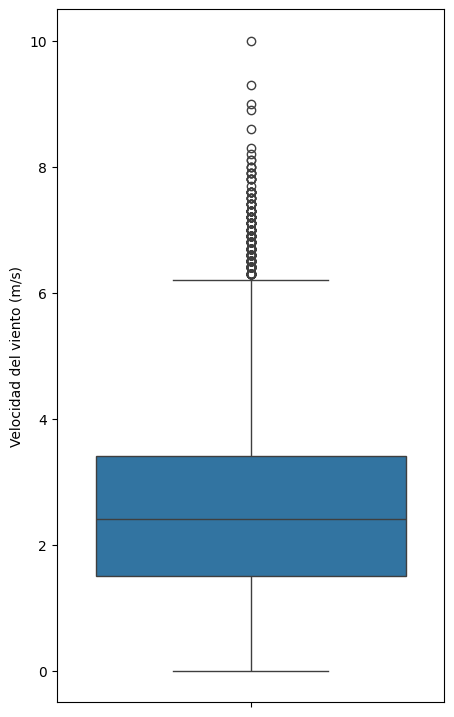

In [5]:
pp.figure( figsize=(5,9) )
sb.boxplot( data = y )
pp.ylabel('Velocidad del viento (m/s)')
pp.show()

### Humedad

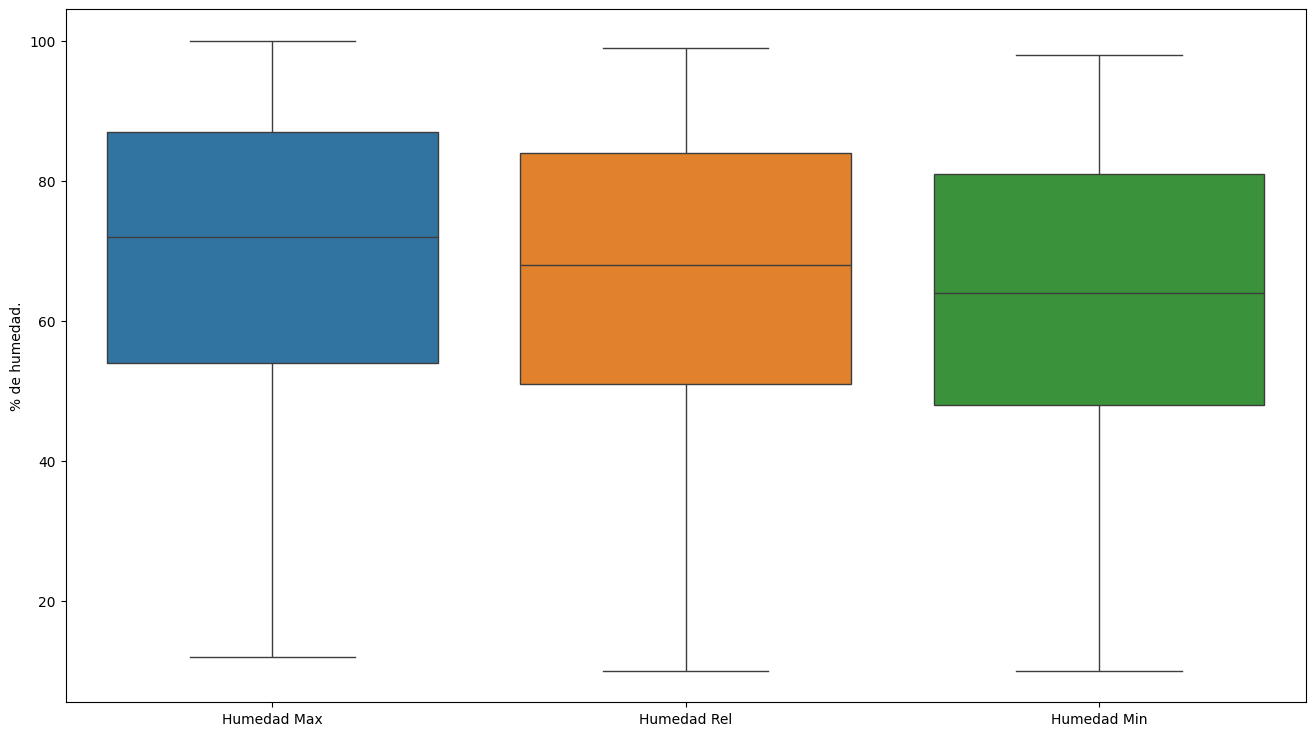

In [6]:
pp.figure(figsize=(16,9))
sb.boxplot( data = X[['Humedad Max', 'Humedad Rel', 'Humedad Min' ]] )
pp.ylabel('% de humedad.')
pp.show()

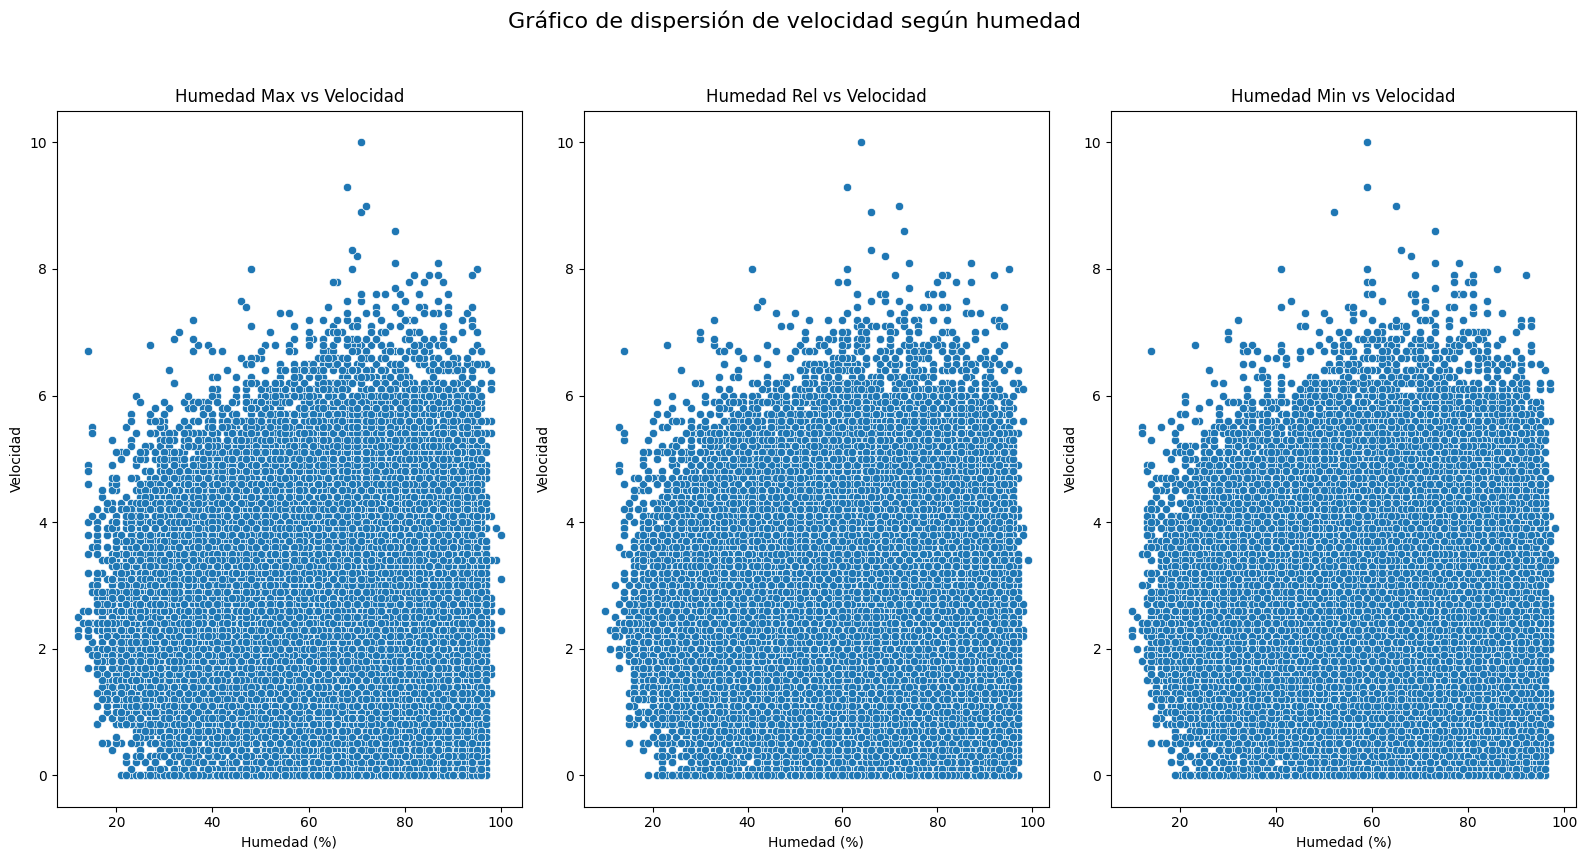

In [7]:
fig, axes = pp.subplots(1, 3, figsize=(16, 9))

categories = ['Humedad Max', 'Humedad Rel', 'Humedad Min']

for i, category in enumerate(categories):
    sb.scatterplot(data=X, x=category, y=y, ax=axes[i])
    axes[i].set_title(f'{category} vs Velocidad')
    axes[i].set_xlabel('Humedad (%)')
    axes[i].set_ylabel('Velocidad')

fig.suptitle('Gráfico de dispersión de velocidad según humedad', fontsize=16)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

pp.show()

### Ráfaga

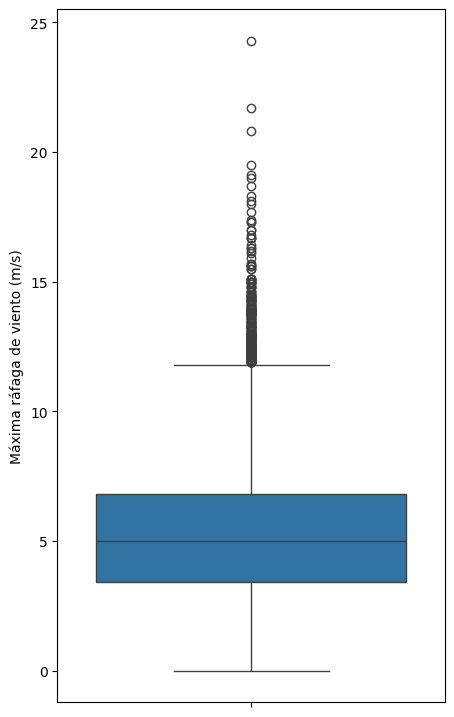

In [8]:
pp.figure( figsize=(5,9) )
sb.boxplot( data = X['Rafaga'])
pp.ylabel('Máxima ráfaga de viento (m/s)')
pp.show()

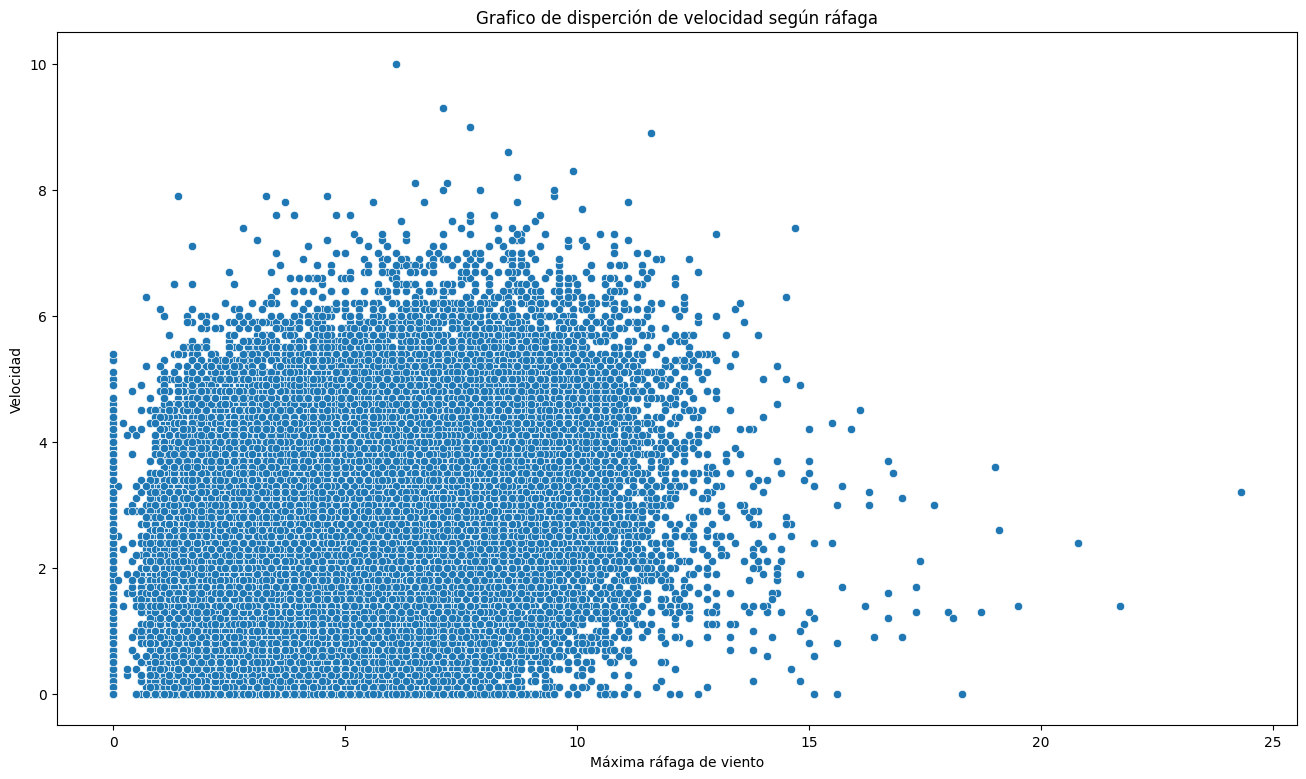

In [9]:
pp.figure( figsize = (16,9) )
sb.scatterplot( data = X, x = 'Rafaga', y = y )
pp.title( 'Grafico de disperción de velocidad según ráfaga' )
pp.xlabel( 'Máxima ráfaga de viento' )
pp.ylabel( 'Velocidad' )
pp.show()

### Temperatura

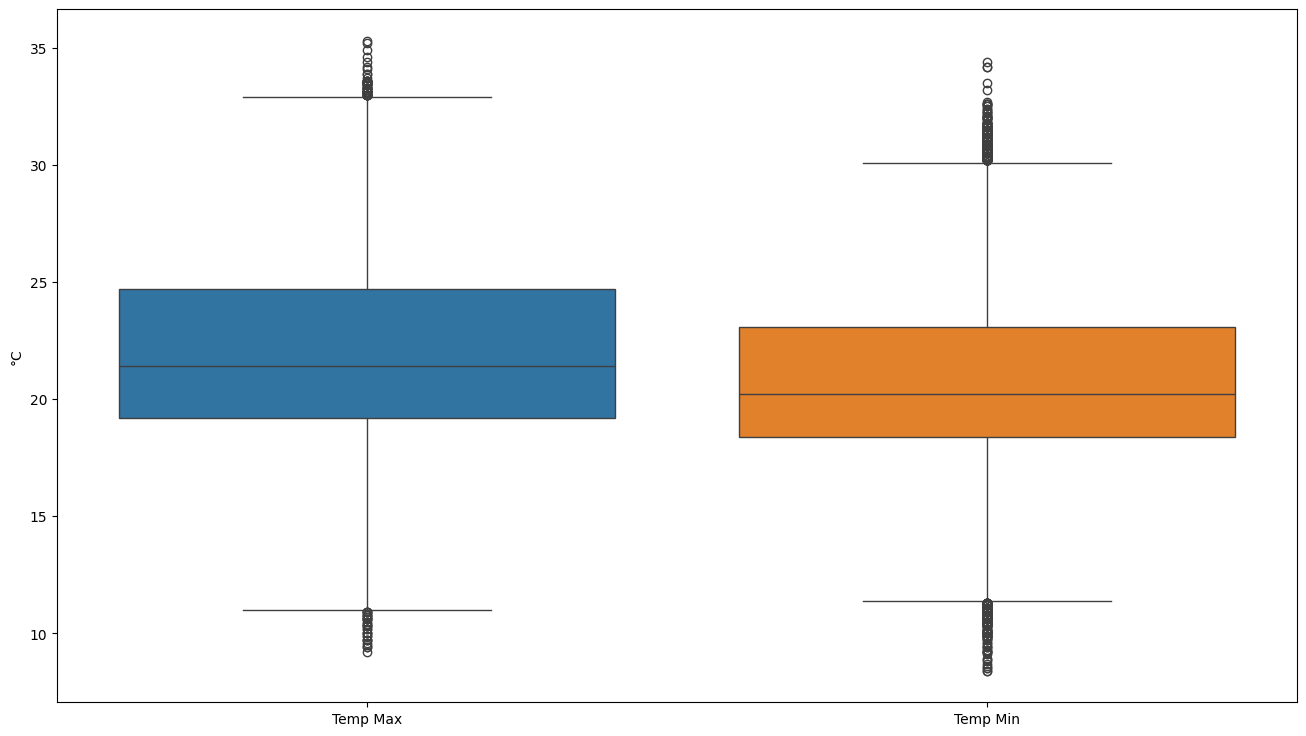

In [10]:
pp.figure(figsize=(16,9))
sb.boxplot( data = X[['Temp Max', 'Temp Min']] )
pp.ylabel('°C')
pp.show()

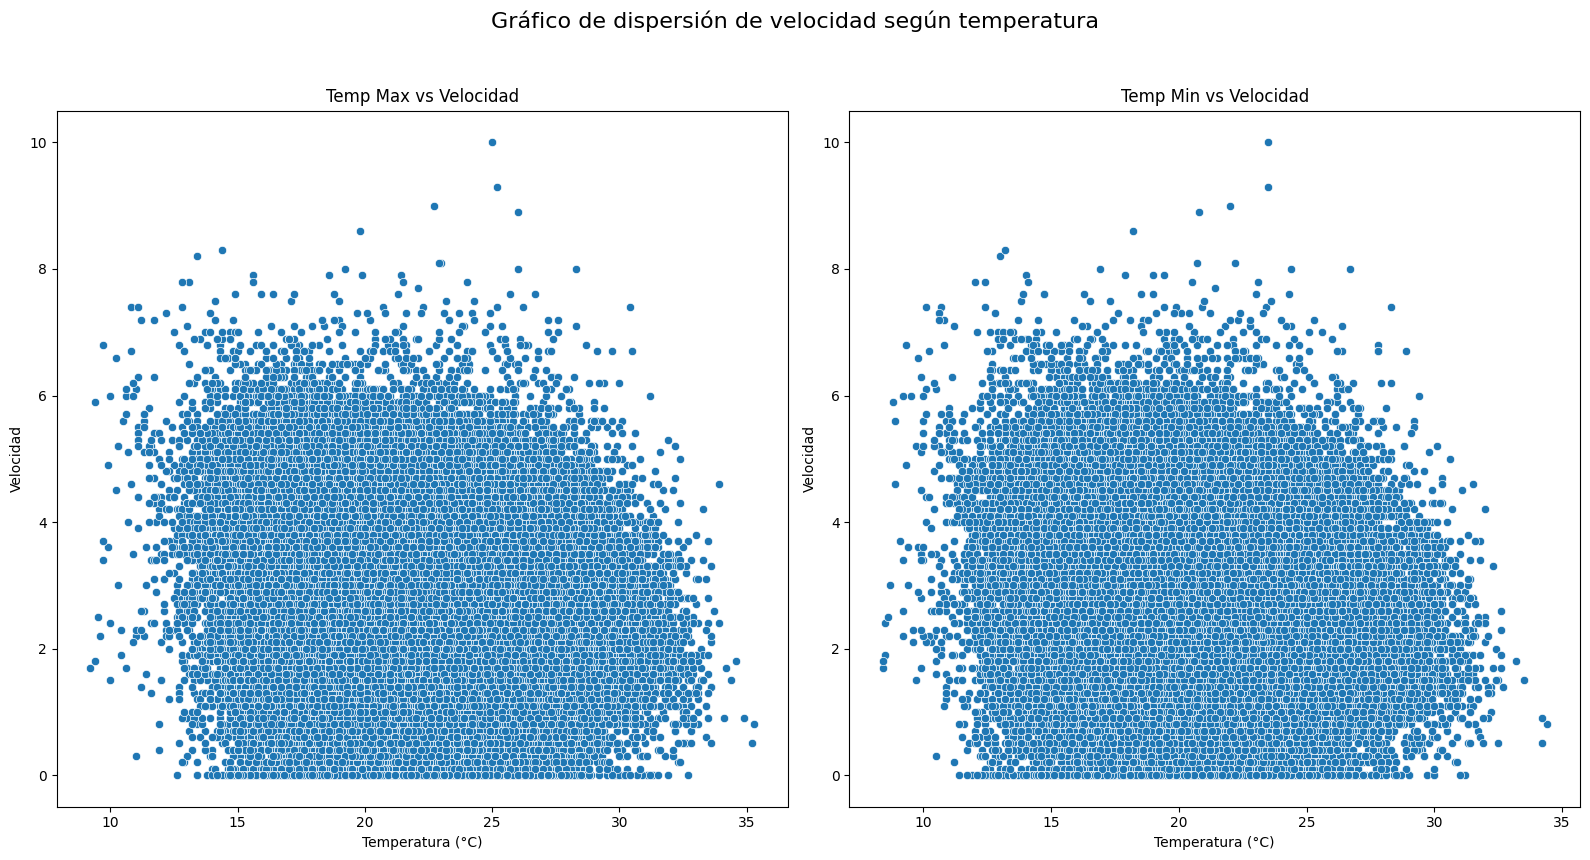

In [11]:
fig, axes = pp.subplots(1, 2, figsize=(16, 9))

categories = ['Temp Max', 'Temp Min']

for i, category in enumerate(categories):
    sb.scatterplot(data=X, x=category, y=y, ax=axes[i])
    axes[i].set_title(f'{category} vs Velocidad')
    axes[i].set_xlabel('Temperatura (°C)')
    axes[i].set_ylabel('Velocidad')

fig.suptitle('Gráfico de dispersión de velocidad según temperatura', fontsize=16)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

pp.show()

### Análisis de componentes principales

De la misma forma que se hizo en el punto anterior, podemos hacer uso de un PCA para visualizar de manera mád sencilla la relación entre el conjunto de datos y la variable respuesta.

In [12]:
with open( root + 'RegFinal.pkl', 'rb') as f:
        X, y, trainCVS, testCVS = load(f)

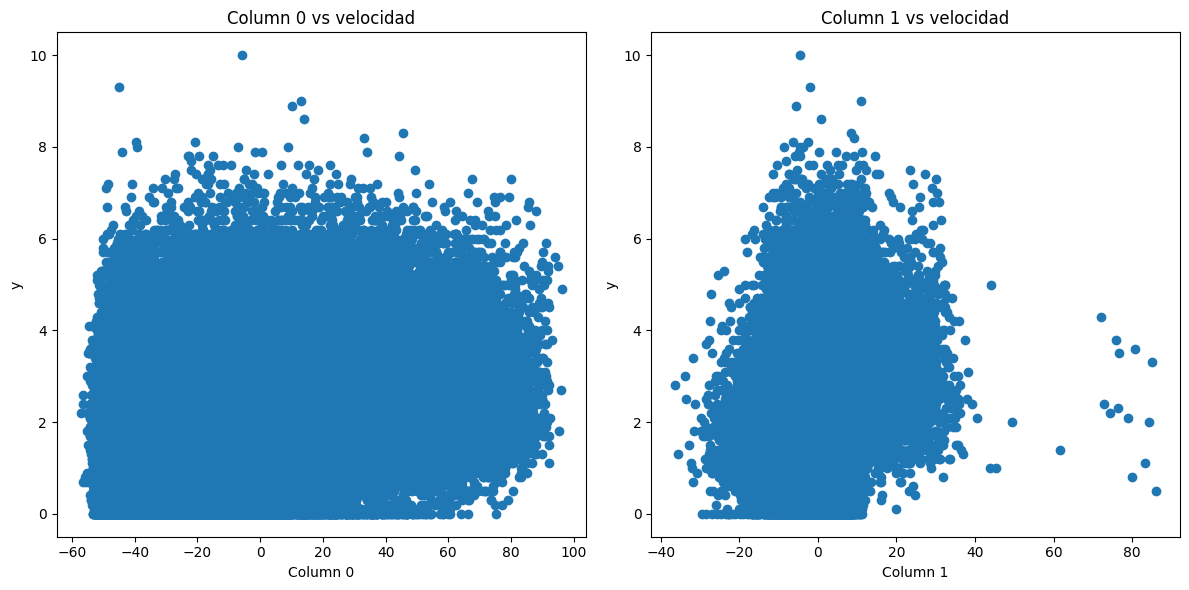

In [13]:
import matplotlib.pyplot as plt

# Plot column 0 against y
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.scatter(X[0], y)
plt.title('Column 0 vs velocidad')
plt.xlabel('Column 0')
plt.ylabel('y')

# Plot column 1 against y
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.scatter(X[1], y)
plt.title('Column 1 vs velocidad')
plt.xlabel('Column 1')
plt.ylabel('y')

# Show the plots
plt.tight_layout()
plt.show()

A simple vista, es complicado encontrar una relación entre las componentes y la respuesta, aún así, podemos ver una tendencia ascendente para la componente 1.

# Parte 3: Modelos de Regresión

Para el entrenamiento de los modelos, se usó una partición especial, que a continuación se muestra.

In [14]:
n = len(X)

CVSplits = [
    [
        (
            range( i * 24, ( i + ( k * 7 ) ) * 24 ),
            range( ( i + ( k * 7 ) ) * 24, ( i + ( k * 7 ) ) * 24 + 24 )
        ) 
        for i in range( ( n - ( k * 7 ) * 24 ) // 24 ) 
    ]
    for k in range( 1, 5 )
]

Podemos analizarlo más detenidamente:

In [15]:
CVSplits[0][0:5]

[(range(0, 168), range(168, 192)),
 (range(24, 192), range(192, 216)),
 (range(48, 216), range(216, 240)),
 (range(72, 240), range(240, 264)),
 (range(96, 264), range(264, 288))]

Dado que cada observación es una hora, las particiones se componen de 168, 336, 504 y 672 horas respectivamente, y se incrementan en 24 horas hasta llegar a la última observación. De esta misma forma están compuestas el resto de particiones.

In [16]:
CVSplits[1][0:5]

[(range(0, 336), range(336, 360)),
 (range(24, 360), range(360, 384)),
 (range(48, 384), range(384, 408)),
 (range(72, 408), range(408, 432)),
 (range(96, 432), range(432, 456))]

In [17]:
CVSplits[2][0:5]

[(range(0, 504), range(504, 528)),
 (range(24, 528), range(528, 552)),
 (range(48, 552), range(552, 576)),
 (range(72, 576), range(576, 600)),
 (range(96, 600), range(600, 624))]

In [18]:
CVSplits[3][0:5]

[(range(0, 672), range(672, 696)),
 (range(24, 696), range(696, 720)),
 (range(48, 720), range(720, 744)),
 (range(72, 744), range(744, 768)),
 (range(96, 768), range(768, 792))]

Cabe aclarar que la última de estas particiones será el set de test para cada respectivo modelo.

In [19]:
with open( root + 'RegFinal.pkl', 'rb') as f:
        X, y, trainCVS, testCVS = load(f)

Dado que en el parcial pasado, no se consiguió completar este punto por cuestiones de tiempo, compararemos los núcleos usados en el modelo entre sí.

In [20]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X, y, splits, time):

    train, test = splits

    X_train, y_train = X.iloc[train], y[train]
    X_test, y_test = X.iloc[test], y[test]

    svr = model.best_estimator_
    svr.fit(X_train, y_train)
    
    y_pred = svr.predict(X_test)
    
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    evaluation_scores = {
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2,
        'CPU time': time
    }
    
    return evaluation_scores

### Kernel RBF

In [21]:
with open( root + 'rbf.pkl', 'rb' ) as f:
    svm_rbf = load( f )

indexesRBF = []
resultsRBF = []

#### Partición semanal

In [22]:
rbf_1 = svm_rbf[0]
print(f"Best score: { rbf_1['model'].best_score_ }")
DataFrame( [rbf_1['model'].best_params_], index = ['RBF 1 sem'] )

Best score: -1.4089751903907752


,classifier__C,classifier__epsilon,classifier__gamma
RBF 1 sem,1.778013,1.0,0.084166


In [23]:
result = evaluate_model( rbf_1['model'], X, y, testCVS[0], rbf_1['time'] )
indexesRBF.append( 'RBF 1 sem' )
resultsRBF.append( result )
DataFrame( [result], index = ['RBF 1 sem'] )

,MAPE,RMSE,R2,CPU time
RBF 1 sem,0.320725,0.980453,-0.189862,786.144255


#### Partición bisemanal

In [24]:
rbf_2 = svm_rbf[1]
print(f"Best score: { rbf_2['model'].best_score_ }")
DataFrame( [rbf_2['model'].best_params_], index = ['RBF 2 sem'] )

Best score: -1.4082428177367747


,classifier__C,classifier__epsilon,classifier__gamma
RBF 2 sem,0.182904,0.065553,0.24578


In [25]:
result = evaluate_model( rbf_2['model'], X, y, testCVS[1], rbf_2['time'] )
indexesRBF.append( 'RBF 2 sem' )
resultsRBF.append( result )
DataFrame( [result], index = ['RBF 2 sem'] )

,MAPE,RMSE,R2,CPU time
RBF 2 sem,0.270604,1.068611,-0.413455,1330.406392


#### Partición trisemanal

In [26]:
rbf_3 = svm_rbf[2]
print(f"Best score: { rbf_3['model'].best_score_ }")
DataFrame( [rbf_3['model'].best_params_], index = ['RBF 3 sem'] )

Best score: -1.4335943399101816


,classifier__C,classifier__epsilon,classifier__gamma
RBF 3 sem,185.321725,0.010638,0.019521


In [27]:
result = evaluate_model( rbf_3['model'], X, y, testCVS[2], rbf_3['time'] )
indexesRBF.append( 'RBF 3 sem' )
resultsRBF.append( result )
DataFrame( [result], index = ['RBF 3 sem'] )

,MAPE,RMSE,R2,CPU time
RBF 3 sem,0.286946,1.209965,-0.812127,1881.695487


#### Partición mensual

In [28]:
rbf_4 = svm_rbf[3]
print(f"Best score: { rbf_4['model'].best_score_ }")
DataFrame( [rbf_4['model'].best_params_], index = ['RBF 4 sem'] )

Best score: -1.4353693532140896


,classifier__C,classifier__epsilon,classifier__gamma
RBF 4 sem,2.368485,0.001405,0.30581


In [29]:
result = evaluate_model( rbf_4['model'], X, y, testCVS[3], rbf_4['time'] )
indexesRBF.append( 'RBF 4 sem' )
resultsRBF.append( result )
DataFrame( [result], index = ['RBF 4 sem'] )

,MAPE,RMSE,R2,CPU time
RBF 4 sem,0.273485,1.25743,-0.957088,3596.866825


De todos estos modelos, podemos ver que el R2 es negativo, y, al contrario de lo que se puede intuir naturalmente, mientras más amplia sea la ventana, peor es el R2. Cabe aclarar que todos estos scores son obtenidos mediante la última partición del set, siguiendo las reglas del entrenamiento previo, por lo que es recomendable usar otro set de particiones para el modelo.

### Kernel Sigmoide

In [30]:
with open( root + 'sigmoid.pkl', 'rb' ) as f:
    svm_sigmoid = load( f )
    
indexesSIG = []
resultsSIG = []

#### Partición semanal

In [31]:
sig_1 = svm_sigmoid[0]
print(f"Best score: { sig_1['model'].best_score_ }")
DataFrame( [sig_1['model'].best_params_], index = ['Sigmoid 1 sem'] )

Best score: -1.5458370941833233


,classifier__C,classifier__epsilon,classifier__gamma
Sigmoid 1 sem,1.562539,0.042991,0.006476


In [32]:
result = evaluate_model( sig_1['model'], X, y, testCVS[0], sig_1['time'] )
indexesSIG.append( 'Sigmoid 1 sem' )
resultsSIG.append( result )
DataFrame( [result], index = ['Sigmoid 1 sem'] )

,MAPE,RMSE,R2,CPU time
Sigmoid 1 sem,0.276174,1.097033,-0.489644,791.999913


#### Partición bisemanal

In [33]:
sig_2 = svm_sigmoid[1]
print(f"Best score: { sig_2['model'].best_score_ }")
DataFrame( [sig_2['model'].best_params_], index = ['Sigmoid 2 sem'] )

Best score: -1.5594884151267245


,classifier__C,classifier__epsilon,classifier__gamma
Sigmoid 2 sem,0.00846,0.000269,130.482648


In [34]:
result = evaluate_model( sig_2['model'], X, y, testCVS[1], sig_2['time'] )
indexesSIG.append( 'Sigmoid 2 sem' )
resultsSIG.append( result )
DataFrame( [result], index = ['Sigmoid 2 sem'] )

,MAPE,RMSE,R2,CPU time
Sigmoid 2 sem,0.291404,1.190747,-0.755017,1409.890641


#### Partición trisemanal

In [35]:
sig_3 = svm_sigmoid[2]
print(f"Best score: { sig_3['model'].best_score_ }")
DataFrame( [sig_3['model'].best_params_], index = ['Sigmoid 3 sem'] )

Best score: -1.4517266359853993


,classifier__C,classifier__epsilon,classifier__gamma
Sigmoid 3 sem,61.908019,0.485734,0.000242


In [36]:
result = evaluate_model( sig_3['model'], X, y, testCVS[2], sig_3['time'] )
indexesSIG.append( 'Sigmoid 3 sem' )
resultsSIG.append( result )
DataFrame( [result], index = ['Sigmoid 3 sem'] )

,MAPE,RMSE,R2,CPU time
Sigmoid 3 sem,0.320549,1.288809,-1.055984,1758.187579


#### Partición mensual

In [37]:
sig_4 = svm_sigmoid[3]
print(f"Best score: { sig_4['model'].best_score_ }")
DataFrame( [sig_3['model'].best_params_], index = ['Sigmoid 3 sem'] )

Best score: -1.4777204575435736


,classifier__C,classifier__epsilon,classifier__gamma
Sigmoid 3 sem,61.908019,0.485734,0.000242


In [38]:
result = evaluate_model( sig_4['model'], X, y, testCVS[3], sig_4['time'] )
indexesSIG.append( 'Sigmoid 3 sem' )
resultsSIG.append( result )
DataFrame( [result], index = ['Sigmoid 3 sem'] )

,MAPE,RMSE,R2,CPU time
Sigmoid 3 sem,0.358024,1.4087,-1.456293,3921.687429


De manera similar al modelo anterior, ninguno de los modelos resultantes es adecuado para la predicción de la velocidad del viento, aunque este es un predictor peor que el kernel previo. Este problema se puede resolver cambiando las particiones o directamente cambiando a un modelo más orientado a series de tiempo. 

## Comparación entre modelos

In [39]:
DataFrame( resultsRBF, index = indexesRBF )

,MAPE,RMSE,R2,CPU time
RBF 1 sem,0.320725,0.980453,-0.189862,786.144255
RBF 2 sem,0.270604,1.068611,-0.413455,1330.406392
RBF 3 sem,0.286946,1.209965,-0.812127,1881.695487
RBF 4 sem,0.273485,1.257430,-0.957088,3596.866825


In [40]:
DataFrame( resultsSIG, index = indexesSIG )

,MAPE,RMSE,R2,CPU time
Sigmoid 1 sem,0.276174,1.097033,-0.489644,791.999913
Sigmoid 2 sem,0.291404,1.190747,-0.755017,1409.890641
Sigmoid 3 sem,0.320549,1.288809,-1.055984,1758.187579
Sigmoid 3 sem,0.358024,1.408700,-1.456293,3921.687429


En estas dos tablas se puede encontrar más claramente lo que se había mencionado antes, los modelos se vuelven peores a medida que aumenta la ventana de entrenamiento. Tambien cabe resaltar que esto tambien aumenta el tiempo de entrenamiento. De todos modos ningún modelo es adecuado para la regresión, aunque el mejor resulta un SVR con kernel RBF y una ventana de 1 semana.